In [1]:
import torch
print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device='cpu'
print(device)
import pytorch_lightning as pl
print(pl.__version__)


/home/langchenliu/anaconda3/envs/cst/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.10.1
cuda
1.6.5


In [2]:
import os, argparse

import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd
import torch #Installed with conda install pytorch torchvision torchaudio cudatoolkit=11.6 -c pytorch -c conda-forge
import glob

import sys
sys.path.append('../')

import continuous_transformer.ContSpaceTime as ContSpaceTime
from continuous_transformer.models_lightning import BERT_Model, BERT_LinearEncoder
from continuous_transformer.continuous_utils import print_nvidia_smi, create_dataloaders_toydata
from continuous_transformer.utils import set_seeds

import pytorch_lightning as pl #Installed with pip install pytorch-lightning
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

from continuous_transformer.sobolev_loss import sobolev_loss

print_nvidia_smi()

Sat Dec 14 16:27:24 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:41:00.0 Off |                  N/A |
| 30%   30C    P8             19W /  350W |      78MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
parser = argparse.ArgumentParser(description='CST')
parser.add_argument('-root_path', metavar='DIR', default='./output',
                    help='path to dataset')

args = parser.parse_args("")

In [4]:
print(os.getcwd())

/home/langchenliu/Desktop/CST


In [10]:
args.model='cst'
args.mode='train'
args.seed = 1
set_seeds(args.seed)
args.batch_size = 2
args.log_per_minibatch=True
args.num_minibatches=10
args.gpu_id = 0
device = torch.device('cuda:'+str(args.gpu_id) if torch.cuda.is_available() else 'cpu')
args.device = device

args.num_dim_plot = 20
args.lr_scheduler = None
args.experiment_name = '50_IE_Spirals' #'Data_RandProj_20pcs_150frames', Data_20pcs_150frames
args.data_dim = 'orig' #'Data_2D', 'Data_10D', 'Data_50D', 'Data_orig'
args.randomly_drop_n_last_frames=None
args.drop_n_last_frames = None
args.num_points_for_c=10
args.resume_from_checkpoint = False
args.downsample_points=100
args.num_seen_points = 0
args.regularly_sampled=True
args.validation_split=0.3
args.use_first_n_frames=500
args.derivtive_order_k = 1
args.norm_power_p = 2

args.compute_loss_whole_curve = False
args.compute_loss_on_dummy_points = True

args.one_curve_per_frame=True

args.add_noise_to_input_data=.1

In [11]:
# -- load dataset
dataloaders = create_dataloaders_toydata(path_file=r"./datasets", 
                                         experiment_name = args.experiment_name, #ToyData_100curves_160points_2D, ToyData_1curve_1kpoints_2D
                                         use_first_n_frames=args.use_first_n_frames,
                                         batch_size_segments=args.batch_size,
                                         validation_split=args.validation_split,
                                         regularly_sampled= args.regularly_sampled,
                                         downsample_points=args.downsample_points,
                                         args=args
                                        )

for dataloader in dataloaders:
    print(f"dataset: {dataloader} \tframes: {len(dataloaders[dataloader].dataset)} \tbatch_size: {dataloaders[dataloader].batch_size}")

Loading  ./datasets/50_IE_Spirals.p
dict_keys(['Data_orig'])
dataset: train 	frames: 100 	batch_size: 2
dataset: val 	frames: 100 	batch_size: 2


obs_.shape:  torch.Size([2, 100, 2, 1])
ts_.shape:  torch.Size([2, 100])
ids_.shape:  torch.Size([2])
frames_to_drop_.shape:  torch.Size([2])


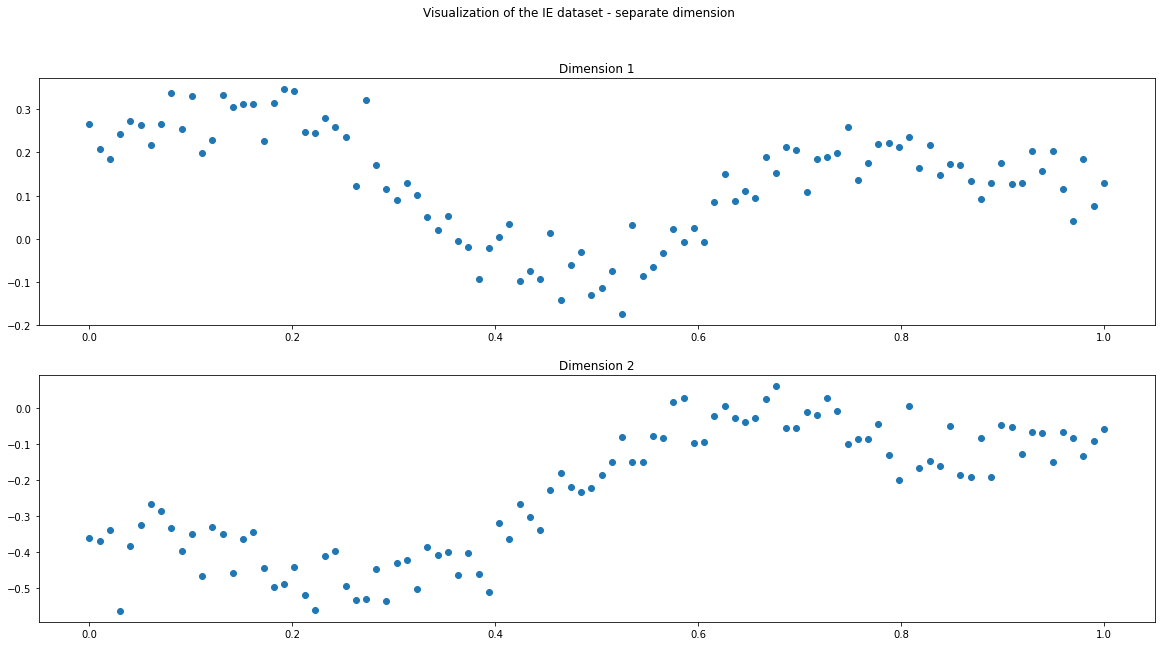

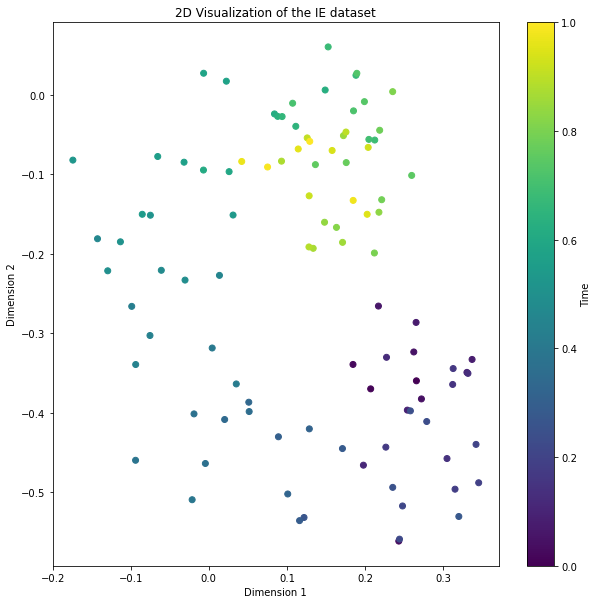

In [13]:
import matplotlib.pyplot as plt

obs_, ts_, ids_, frames_to_drop_ = next(iter(dataloaders['train']))
print('obs_.shape: ', obs_.shape)
print('ts_.shape: ', ts_.shape)
print('ids_.shape: ', ids_.shape)
print('frames_to_drop_.shape: ', frames_to_drop_.shape)

idx_batch = 0
%matplotlib inline

# Plot for separate dimensions
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax = ax.ravel()
for idx in range(2):
    ax[idx].scatter(ts_[idx_batch], obs_[idx_batch, :, idx], vmin=-0.5, vmax=0.5)
    ax[idx].set_title(f'Dimension {idx + 1}')
fig.suptitle('Visualization of the IE dataset - separate dimension')
plt.savefig('separate_dimensions_plot.png')
plt.show()

# Plot for 2D dataset
fig, ax = plt.subplots(figsize=(10, 10))
sc = ax.scatter(obs_[idx_batch, :, 0], obs_[idx_batch, :, 1], c=ts_[idx_batch], cmap='viridis')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_title('2D Visualization of the IE dataset')
plt.colorbar(sc, label='Time')
plt.savefig('2d_dataset_plot.png')
plt.show()

In [8]:
# -- load model and parameters for training and logging

# -- metadata for saving checkpoints
str_model_name = "CST"
str_model_type = args.experiment_name# options: linear_encoder; conv_encoder (not implemented yet)
str_model = f"{str_model_name}-{str_model_type}"
str_log_dir = args.root_path

path_to_experiment = str_log_dir+'/'+str_model
print('path_to_experiment: ',path_to_experiment)

# Create dir to save outputs
os.makedirs(path_to_experiment,exist_ok=True)
txt = os.listdir(path_to_experiment)

txt = [x for x in txt if not x.startswith('@$\t') and not x.startswith('eval_')]
if len(txt) == 0:
    num_experiments=0
else: 
    num_experiments = [int(i[8:]) for i in txt]
    num_experiments = np.array(num_experiments).max()
            
print('version: ',num_experiments+1)
path_to_save_models = path_to_experiment+'/version_'+str(num_experiments+1)

# -- logger location
logger = TensorBoardLogger(str_log_dir, name=str_model,version=num_experiments+1)


# -- model checkpoint callback
# -- saves a file like: path/to/dir/sample-epoch=02-val_loss=0.32.ckpt
os.makedirs(os.path.join(logger.log_dir, "plots"), exist_ok=True) # create dir to avoid path does not exist error
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath=f"{logger.log_dir}/",
    filename=str_model + "-{epoch:05d}-{val_loss:.6f}-{val_r2:.2f}",
    save_top_k=2,
    mode="min",
)

# -- early stop callback
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=5000, verbose=False, mode="min", check_finite=False)

# -- init model
# -- could move these cfgs into functions

model_cfg = {
    "model_type": str_model_type,
    "dim": 32,
    "fast_attention": False, # Set to True to use linear attention
    "attention_type": 'quad', 
    "num_landmarks": 10, # Used for the nystroformer
    "operation_with_pos_encoding": "sum", # "concatenate" or "sum". For 
    "penalty_orthogonality": 1,
    "dim_ff": 3072,
    "n_layers": 4,
    "p_drop_attn": 0.8,
    "use_softmax": True,
    "n_heads": 4,
    "p_drop_hidden": 0.1,
    "vocab_size": len(dataloaders[dataloader].dataset),
    "max_len": args.downsample_points,
    "n_segments": 1,
    "frame_size": {'rows': obs_.shape[2], 'cols': obs_.shape[3]}, #184, 208
    "patch_size": np.array([obs_.shape[2],obs_.shape[3]]), #Num patches = (208/8)*(208/8) = 598 patches/frame. If patch_size is empty, use patch_size==frame_size
    "range_imshow": None,
    "scale_gauss": None, 
    "plot_predictions": True,
    "plot_training_curves": False,
    "plot_every_epochs": 10,
    "plot_att_weights" : False,
}

patch_sampling_cfg = {
    "num_frames": args.downsample_points, #segment_size, # number of frames to use
    "num_patches": 6, # number of patches to sample from frames. If patch_size is less than frame_size, num_patches represents the number of frames being selected (temporal sparsity)
    "structure": "grid", # options: random, grid (only used if predicting patches)
    "num_patches_to_hide": (model_cfg["frame_size"]["rows"]//model_cfg["patch_size"][0])*(model_cfg["frame_size"]["cols"]//model_cfg["patch_size"][1]),
    "n_frames_to_hide": args.downsample_points - args.num_seen_points, # if n_frames_to_hide=1, only the last frame is masked and predicted. If >1, 3 random frames of the sequence are used.
    "num_in_between_frames": 100, # Number of dummy points that will be added
    "in_between_frame_init": "interpolation", # options: 'mask' sets the dummy frames to 0.5; 'random' sets the dummy frames to gaussian with mean 0 and std=0.1; "inteporlation" initializes the dummy and masked frames as an inteprolation of the visible frames
    "interpolation_kind" : "linear",
    "batch_size_segments": args.batch_size,# batch_size_segments,
    "prob_replace_masked_token": 1.0,
    "sampling_type" : 'regular', #'random' or 'regular'
    "masking_type" : "random_masking",# "last_n_points" masks the last n points defined by n_frames_to_hide. "equal_spaced" distributes the masked points equally betwen visible ones. "random_masking" randomly masks 
    "mode": "" # In "inference", the frames are chosen manualy 
} 

train_cfg = {
    "learning_rate": 1e-3,
    "weight_decay": 1e-7 ,
    "segment_size": str(args.downsample_points), 
    "experiment_name": args.experiment_name,
    "compute_loss_whole_curve":args.compute_loss_whole_curve,
    "compute_loss_on_dummy_points":args.compute_loss_on_dummy_points,
    "weight_loss_on_real" : 0.5,
    "derivtive_order_k": 3, 
    "norm_power_p": 3, 
    "use_mean_sobolev": False,
    "factor_sobolev":.01,
    "use_mse":True,
    "std_noise_t": 0.,
    "std_to_data":.1,
}

loss_func = sobolev_loss(k=train_cfg["derivtive_order_k"],p=train_cfg["norm_power_p"],
                         dim=obs_.shape[2],bs=args.batch_size,data_length=20,minimize=True,
                         diff_mode='central',factor = train_cfg["factor_sobolev"])

model = BERT_Model(model_cfg,
                   patch_sampling_cfg,
                   train_cfg,my_loss=loss_func,
                   path_to_save_models=path_to_save_models,
                   warmup=0)

if 'resume_from_checkpoint' in train_cfg:
    print('Loading BERT checkpoint model {}'.format(train_cfg['resume_from_checkpoint']))
    try: 
        list_of_checkpoints = glob.glob(os.path.join(str_log_dir,str_model,train_cfg['resume_from_checkpoint'],'*.ckpt')) # * means all if need specific format then *.csv
        latest_checkpoint = max(list_of_checkpoints, key=os.path.getctime)
        print('Loading ', latest_checkpoint)
        model = BERT_Model.load_from_checkpoint(latest_checkpoint)
    except:
        print('Loading failed')
    
# with open(f"{logger.log_dir}/readme.txt", "w+") as txt:
#     print(readme, file=txt)
    
print(model)
print(f"logging to {logger.log_dir}")

# -- create pytorch lightning trainer and fit model to data
# -- trainer
trainer = pl.Trainer(max_epochs=10000,
                     accelerator='gpu',
                     devices = [args.gpu_id],
                     logger=logger,
                     fast_dev_run=False, # 'True' to run 1 train, val, test batch and program ends
                     enable_progress_bar=False, #'False' to disable the progress bar
                     log_every_n_steps=1,
                     callbacks=[early_stop_callback,
                                checkpoint_callback])

trainer.fit(model, dataloaders['train'], dataloaders['val'])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


path_to_experiment:  ./output/CST-50_IE_Spirals
version:  5
model_type:  50_IE_Spirals
model type 'grid' not recognized, using 'linea_encoder' instead
BERT_Model(
  (model): BERT_LinearEncoder(
    (transformer): Transformer(
      (embed): Embeddings(
        (pos_embed): Embedding(10, 32)
        (pos_embed_3DLin): Linear(in_features=3, out_features=32, bias=True)
        (norm): LayerNorm()
        (drop): Dropout(p=0.1, inplace=False)
      )
      (blocks): ModuleList(
        (0): Block(
          (attn): MultiHeadedSelfAttention(
            (proj_q): Linear(in_features=32, out_features=32, bias=True)
            (proj_k): Linear(in_features=32, out_features=32, bias=True)
            (proj_v): Linear(in_features=32, out_features=32, bias=True)
            (drop): Dropout(p=0.8, inplace=False)
          )
          (proj): Linear(in_features=32, out_features=32, bias=True)
          (norm1): LayerNorm()
          (pwff): PositionWiseFeedForward(
            (fc1): Linear(in_feat

/home/langchenliu/anaconda3/envs/cst/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /home/langchenliu/Desktop/CST/output/CST-50_IE_Spirals/version_5 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type               | Params
---------------------------------------------
0 | model | BERT_LinearEncoder | 818 K 
---------------------------------------------
818 K     Trainable params
0         Non-trainable params
818 K     Total params
3.272     Total estimated model params size (MB)



Best validation loss: 9.497203826904297
Saving best model for epoch: 1


Best validation loss: 0.6484081149101257
Saving best model for epoch: 2


Best validation loss: 0.4822389781475067
Saving best model for epoch: 3


Lower validation loss still: 0.4822389781475067

Lower validation loss still: 0.4822389781475067

Lower validation loss still: 0.4822389781475067

Lower validation loss still: 0.4822389781475067

Best validation loss: 0.3923528790473938
Saving best model for epoch: 8


Lower validation loss still: 0.3923528790473938

Lower validation loss still: 0.3923528790473938

Best validation loss: 0.36953800916671753
Saving best model for epoch: 11


Lower validation loss still: 0.36953800916671753

Lower validation loss still: 0.36953800916671753

Lower validation loss still: 0.36953800916671753

Best validation loss: 0.3487274944782257
Saving best model for epoch: 15


Lower validation loss still: 0.3487274944782257

Lower validation loss still: 0.3487274944782257

Lower valid

/home/langchenliu/anaconda3/envs/cst/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
